<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-исследования" data-toc-modified-id="Цель-исследования-1">Цель исследования</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2">Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3">Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4">Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1">Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2">Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-4.3">Решающее дерево</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4">CatBoost</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-4.5">Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5">Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6">Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Цель исследования

**Цель нашего исследования** — обучить модель для прогнозирования количества заказов такси на следующий час. Это необходимо, чтобы привлекать больше водителей к заказам в период пиковой нагрузки. 


**Этапы исследования:**

1. Обучить несколько моделей с различными гиперпараметрами.
2. Проверить лучшую модель на тестовой выборке (10% от данных).
3. Добиться значения метрики RMSE не более 48.



## Подготовка данных

In [1]:
#!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
plt.style.use('dark_background')
warnings.filterwarnings('ignore')

In [3]:
try:
    d = pd.read_csv('/datasets/taxi.csv')
except:
    d = pd.read_csv('/content/taxi.csv')

In [4]:
# Делаем функцию для обзора данных
def data_overview(data):
    '''
    Функция для обзора данных,
    принимает на вход датафрейм,
    выводит на экран его основные характеристики
    и графики
    '''
    
    print('Общая информация о данных (info)', (80 - len('Общая информация о данных (info)')) * '-', '\n')
    data.info()
    print('')
    print('Статистические показатели (describe)', (80 - len('Статистические показатели (describe)')) * '-')
    display(data.describe().T)
    print('')
    print ('Пропущенные значения в данных', (80 - len('Пропущенные значения в данных')) * '-')
    print('')
    empty = sum(data.isna().sum())
    if empty > 0:
        print(f'Общее количество пропусков в данных: {empty}')
        print()
        (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', legend = False, figsize=(40,20),
                  fontsize = 22)
            .set_title('Количество пропусков по колонкам' + "\n", fontsize = 26)
        )
    else:
        print('Пропущенных значений нет')
    print('')
    print('Дубликаты в данных', (80 - len('Дубликаты в данных')) * '-')
    print('')
    if data.duplicated().sum() > 0:
        print (f'Количество дубликатов в данных: {data.duplicated().sum()}')
    else:
        print('Дубликатов нет')
    

In [5]:
data_overview(d)

Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

Статистические показатели (describe) --------------------------------------------


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0



Пропущенные значения в данных ---------------------------------------------------

Пропущенных значений нет

Дубликаты в данных --------------------------------------------------------------

Дубликатов нет


Изменим тип данных c object на datetime у столбца `datetime` и сделаем этот столбец индексом.

In [6]:
d['datetime'] = pd.to_datetime(d['datetime'])

In [7]:
d = d.set_index('datetime')
d = d.sort_index()
d.index.is_monotonic

True

Сделаем ресемплинг данных по часам.

In [8]:
d = d.resample('1H').sum()

In [9]:
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Посмотрим на такие характеристики временного ряда, как тренд, сезонность и остаток.

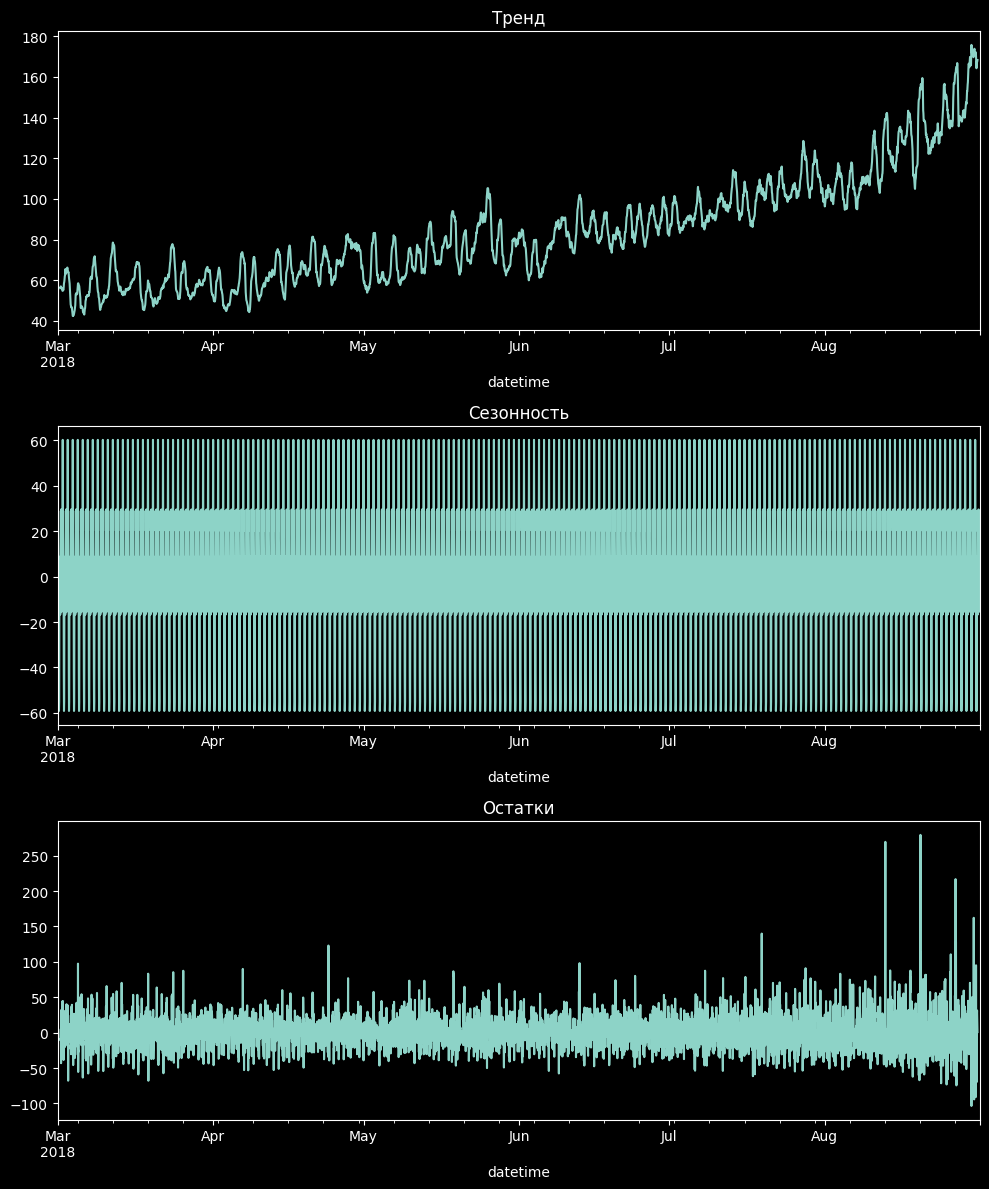

In [10]:
dd = seasonal_decompose(d) 

plt.figure(figsize=(10, 12))
plt.subplot(311)
dd.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
dd.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
dd.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout();

На графике виден восходящий тренд. Посмотрим на сезонность на меньшем интервале. Возьмем неделю в марте.

In [11]:
dd_week = seasonal_decompose(d['2018-03-01':'2018-03-07']) 

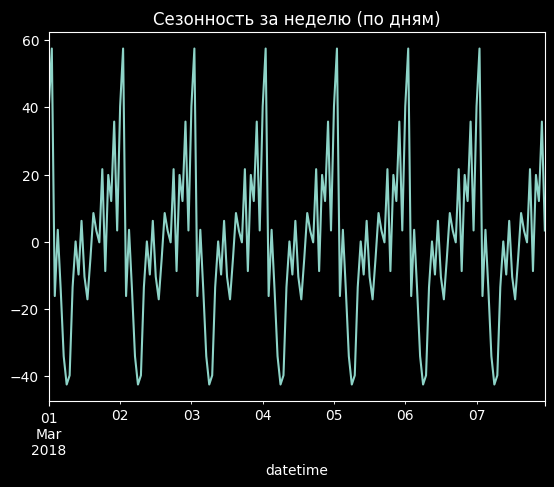

In [12]:
dd_week.seasonal.plot()
plt.title('Сезонность за неделю (по дням)');

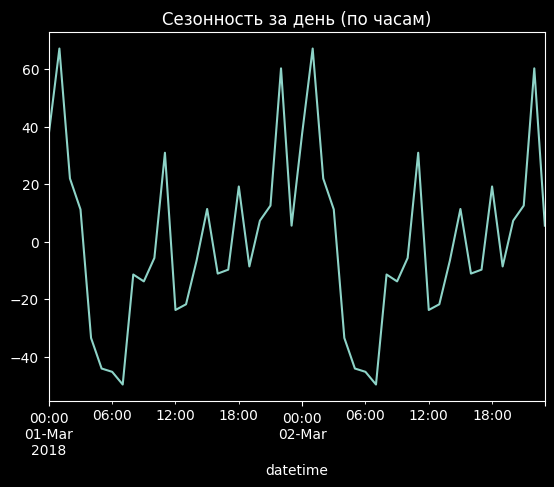

In [13]:
dd_day = seasonal_decompose(d['2018-03-01':'2018-03-02'])
dd_day.seasonal.plot()
plt.title('Сезонность за день (по часам)');


На графиках видно, что у нашего ряда есть стационарные сезонные колебания в течение дня — в начале дня дня (рано утром) спрос на такси падает, затем, к полудню, растет, есть пиковый спрос в вечернее время (около 22:00) и сразу после полуночи, затем, ночью, спрос падает и достигает минимума в районе 6 часов утра.

## Обучение

### Подготовка данных

Сначала извлечем нужные признаки из данных — месяц, день, день недели, скользящее среднее и лаги. Максимальный лаг возьмем равным неделе, а скользящее среднее будем считать в интервале 24 часа.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



In [15]:
new_d = d.copy()
make_features(new_d, 1, 24)
new_d

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


In [16]:
# Разбиваем данные на обучающую и тестовую выборки
train, test = train_test_split(new_d, shuffle=False, test_size=0.1)

# Удаляем пропуски, образовавшиеся после сдвига
train = train.dropna()

# Выделяем в обучающих и тестовых данных фичи и целевой признак
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Линейная регрессия


Обучим модель линейной регрессии. Для кросс-валидации будем использовать метод time series split, поскольку он учитывает особенности работы с временным рядом (значения из будущего не должны попадать в валидационный набор).

In [17]:
lr_model = LinearRegression()
lr_params = {}

lrm_rs = RandomizedSearchCV(lr_model, 
                            lr_params, 
                            scoring='neg_root_mean_squared_error', 
                            random_state=1508, 
                            cv=TimeSeriesSplit(n_splits=8))

lrm_rs.fit(features_train, target_train)
print('RMSE линейной регрессии:', (rmse_lrm := abs(lrm_rs.best_score_)))

RMSE линейной регрессии: 31.366763577025026


Мы получили значение 31,4 у метрики RMSE на линейной регрессии.

### Решающее дерево

Обучим модель дерева. Подберем оптимальные гиперпараметры с помощью randomized search.

In [18]:
tree = DecisionTreeRegressor(random_state=1508)
tree_params = {'max_depth': range(2, 100, 10),
              'min_samples_split': range(2, 10, 2)}

tree_rs = RandomizedSearchCV(tree, 
                            tree_params, 
                            scoring='neg_root_mean_squared_error', 
                            random_state=1508, 
                            cv=TimeSeriesSplit(n_splits=8))

tree_rs.fit(features_train, target_train)
print('RMSE дерева:', (rmse_tree := abs(tree_rs.best_score_)))

RMSE дерева: 29.405411365954755


Значение RMSE у модели решающего дерева ниже, чем у линейной регрессии, — 29,4.

### CatBoost 

Обучим модель CatBoost. Также подберем оптимальные гиперпараметры с помощью randomized search.

In [19]:
%%time
catm = CatBoostRegressor(random_state=1508)

catm_params = {'n_estimators': range(25, 100, 10),
               'max_depth': [10, 15, 25]}

catm_rs = RandomizedSearchCV(catm, 
                             catm_params, 
                             scoring='neg_root_mean_squared_error', 
                             random_state=1508, 
                             cv=TimeSeriesSplit(n_splits=8))

catm_rs.fit(features_train, target_train, verbose=False)

CPU times: user 9min 22s, sys: 6min 23s, total: 15min 46s
Wall time: 11min 7s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f7d0b00b3a0>,
                   param_distributions={'max_depth': [10, 15, 25],
                                        'n_estimators': range(25, 100, 10)},
                   random_state=1508, scoring='neg_root_mean_squared_error')

In [20]:
rmse_cat = abs(catm_rs.best_score_)

RMSE модели CatBoost меньше, чем у леса — 25.

In [21]:
catm_rs.best_params_

{'n_estimators': 55, 'max_depth': 10}

### Вывод по разделу

In [22]:
final_metrics = pd.DataFrame(
    data = [rmse_lrm, rmse_tree, rmse_cat],
    index = ['Линейная регрессия', 'Дерево', 'CatBoost'],
    columns = ['RMSE']
)
final_metrics

,RMSE
Линейная регрессия,31.366764
Дерево,29.405411
CatBoost,25.069151


Мы обучили три модели — линейную регрессию, дерево и CatBoost. Наилучший результат по метрике RMSE показала модель CatBoost — 25. Эту модель мы и будем проверять на тестовой выборке.

## Тестирование

Протестируем нашу лучшую модель.

In [25]:
test_preds = catm_rs.best_estimator_.predict(features_test)
print('RMSE модели CatBoost на тесте:', (mean_squared_error(target_test, test_preds))**0.5)

RMSE модели CatBoost на тесте: 44.64644860587923


RMSE модели CatBoost на тестовой выборке — около 45. Поставленная задача выполнена. Визуализируем предсказанные и целевые значения.

In [26]:
test_preds=pd.DataFrame(data = test_preds, index = target_test.index)


In [27]:
test_preds = test_preds.rename(columns={0:'num_orders'})

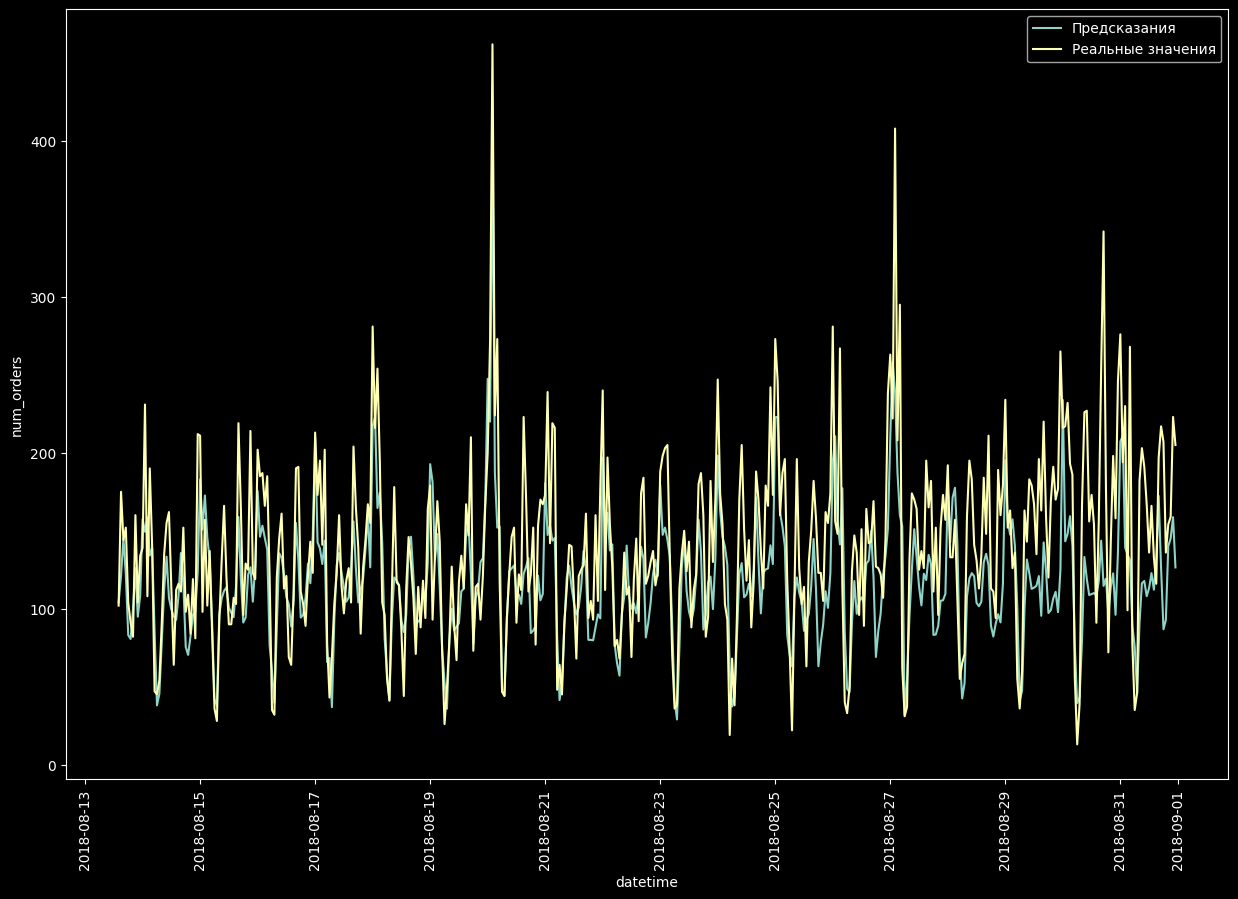

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=test_preds['num_orders'], label='Предсказания')
sns.lineplot(data=target_test.to_frame()['num_orders'], label='Реальные значения')
plt.legend()
plt.xticks(rotation=90);

Сократим интервал до недели.

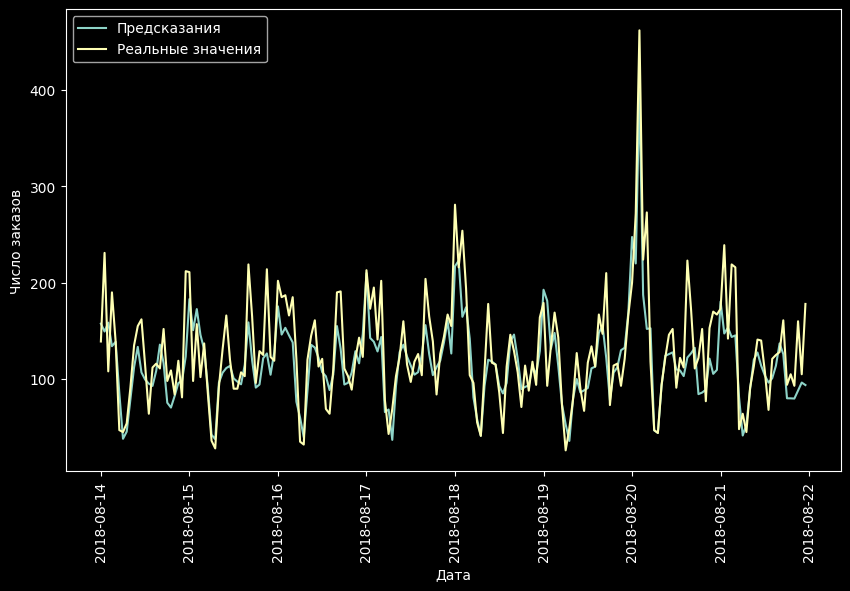

In [29]:
plt.figure(figsize=(10,6))
sns.lineplot(data=test_preds.loc['2018-08-14':'2018-08-21', 'num_orders'], label='Предсказания')
sns.lineplot(data=target_test.to_frame().loc['2018-08-14':'2018-08-21', 'num_orders'], label='Реальные значения')
plt.ylabel('Число заказов')
plt.xlabel('Дата')
plt.legend()
plt.xticks(rotation=90);

###Вывод по разделу
Модель CatBoost показала на тестовой выборке значение RMSE 45. Поставленная задача выполенена.